##### 101 Formulaic Alphas
- Based on [101 Formulaic Alphas](https://arxiv.org/pdf/1601.00991.pdf), Zura Kakushadze, arxiv, 2015

##### Imports & Settings

In [1]:
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection \
        import mutual_info_regression
        
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
idx= pd.IndexSlice
sns.set_style('whitegrid')

##### Loading Data

In [4]:
## Top 500 dataset

ohlcv = ['open', 'high', 'low', 'close', 'volume']

DATA_STORE = Path('/home/sayem/Desktop/Project/data/assets.h5')

lock_path = "/tmp/assets_h5_file.lock"  # Choose a path for the lock file

from filelock import FileLock

with FileLock(lock_path):
    with pd.HDFStore(DATA_STORE) as store:
        data = (store['data/top500_dataset']
                .loc[:, ohlcv + ['ret_01d', 'sector', 'ret_fwd_01d']]
                .rename(columns={'ret_01d': 'returns'})
                .sort_index())

In [5]:
# Meta Labeling
data_ohlcv = data[['open', 'high', 'low', 'close', 'volume']].copy()
T = data['ret_fwd_01d'].std()
data['primary_target'] = (data['ret_fwd_01d'].abs() > T).astype(int)

data['secondary_target'] = np.where(data['primary_target'] == 1, 
                                    np.where(data['ret_fwd_01d'] > 0, 1, -1),
                                    np.nan)

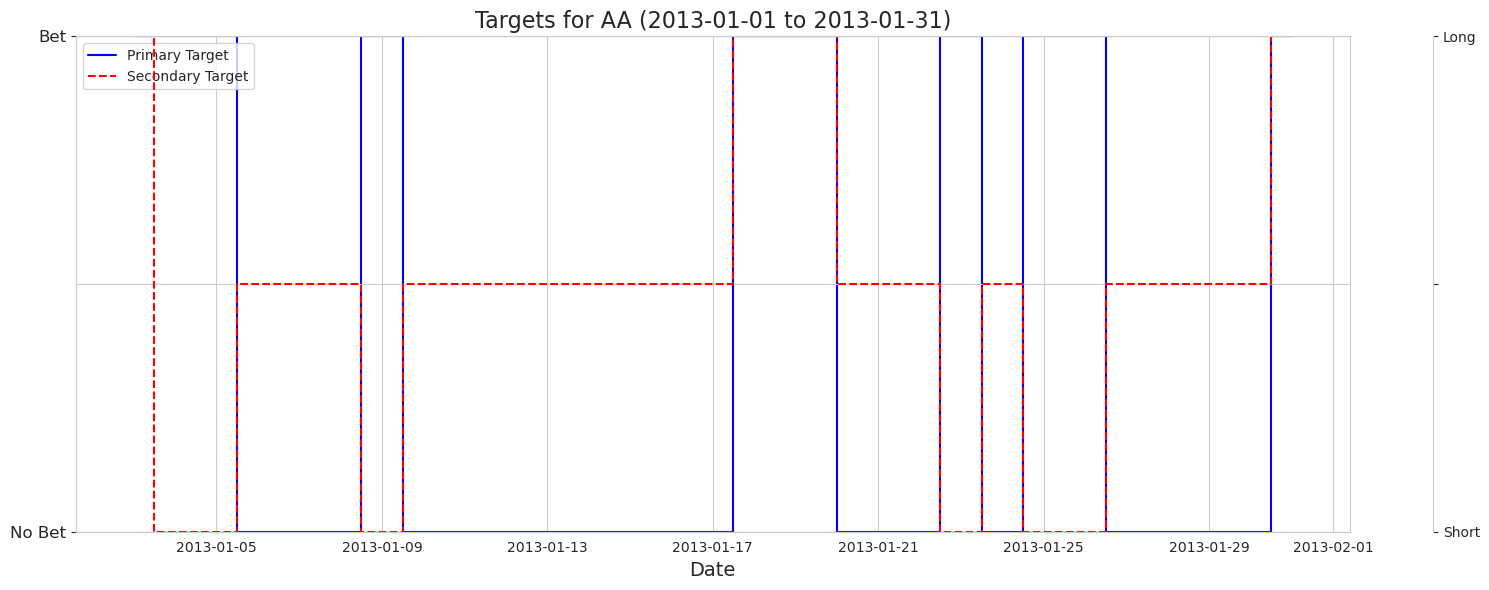

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_targets(data):
    # Primary model's target
    threshold = 0.01  # Threshold for returns; for demonstration purposes
    data['primary_target'] = np.where(data['ret_fwd_01d'].abs() > threshold, 1, 0)

    # Secondary model's target
    data['secondary_target'] = np.where(data['ret_fwd_01d'] > 0, 1, -1)
    data['secondary_target'] = data['secondary_target'] * data['primary_target']

    return data

def plot_targets(data, ticker, start_date, end_date):
    # Filter data for the given ticker and time frame
    data_filtered = compute_targets(data.loc[ticker].loc[start_date:end_date])

    # Set up the plot
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plotting primary target
    line1, = ax1.step(data_filtered.index, data_filtered['primary_target'], \
                      label='Primary Target', where='mid', color='blue')

    # Right axis for secondary target
    ax2 = ax1.twinx()
    line2, = ax2.step(data_filtered.index, data_filtered['secondary_target'], \
                      color='red', label='Secondary Target', where='mid', linestyle='--')
    
    ax1.set_title(f'Targets for {ticker} ({start_date} to {end_date})', fontsize=16)
    ax1.set_xlabel('Date', fontsize=14)
    
    # Left axis for primary target
    ax1.set_ylim(0, 1)
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['No Bet', 'Bet'], fontsize=12)

    # Right axis for secondary target
    ax2.set_ylim(-1, 1)
    ax2.set_yticks([-1, 0, 1])
    ax2.set_yticklabels(['Short', '', 'Long'], fontsize=12)

    # Adjusting legend
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    # Pad the spacing between the two y-axes
    ax2.spines['right'].set_position(('outward', 60))  
    ax2.yaxis.set_ticks_position('right')
    ax2.yaxis.set_label_position('right')

    plt.tight_layout()
    plt.show()

# To use the function:
plot_targets(data, 'AA', '2013-01-01', '2013-01-31')

In [ ]:
adv20 = data.groupby('ticker').rolling(20).volume.mean().reset_index(0, drop=True)
data = data.assign(adv20=adv20)
data = data.join(data.groupby('date')[ohlcv].rank(axis=1, pct=True), rsuffix='_rank')
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1355775 entries, ('AA', Timestamp('2013-01-03 00:00:00')) to ('ZTS', Timestamp('2023-08-10 00:00:00'))
Data columns (total 14 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   open         1355775 non-null  float32
 1   high         1355775 non-null  float32
 2   low          1355775 non-null  float32
 3   close        1355775 non-null  float32
 4   volume       1355775 non-null  float64
 5   returns      1355775 non-null  float32
 6   sector       1355775 non-null  float32
 7   ret_fwd_01d  1355775 non-null  float32
 8   adv20        1346239 non-null  float64
 9   open_rank    1355775 non-null  float64
 10  high_rank    1355775 non-null  float64
 11  low_rank     1355775 non-null  float64
 12  close_rank   1355775 non-null  float64
 13  volume_rank  1355775 non-null  float64
dtypes: float32(7), float64(7)
memory usage: 113.9+ MB


In [ ]:
data = data[~data.index.duplicated(keep='first')]
o = data.open.unstack('ticker')
h = data.high.unstack('ticker')
l = data.low.unstack('ticker')
c = data.close.unstack('ticker')
v = data.volume.unstack('ticker')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.returns.unstack('ticker')

datasets = {
    'o': o,
    'h': h,
    'l': l,
    'c': c,
    'v': v,
    'r': r,
    'adv20': adv20,
    'vwap': vwap  
}

In [ ]:
import inspect

def apply_alpha_function(alpha_number, datasets):
    """
    Apply the given alpha function (by number) to the datasets.

    Args:
    - alpha_number (int): The number of the alpha function to apply (e.g., 1, 2, 3...)
    - datasets (dict): A dictionary containing the available datasets.

    Returns:
    - The result of the alpha function applied to the datasets.
    """
    # Get the alpha function based on the number
    alpha_func_name = f'alpha{alpha_number:03}'
    if alpha_func_name not in globals():
        raise ValueError(f"No function named {alpha_func_name} found!")
    alpha_func = globals()[alpha_func_name]  # Fetch directly from globals dictionary

    # Get the list of arguments that the function expects
    expected_args = inspect.signature(alpha_func).parameters.keys()

    # Filter the datasets to only include the expected arguments
    filtered_datasets = {k: v for k, v in datasets.items() if k in expected_args}

    # Apply the function using ** to unpack the dictionary into function arguments
    return alpha_func(**filtered_datasets)

In [ ]:
# ## Serial code

# from formulaic_alphas import *  # Make sure this import is present

# # Define your datasets
# # [Your dataset definitions here...]

# alphas = data[['returns', 'ret_fwd_01d']].copy()

# success_count = 0  # Counter to keep track of successfully applied alphas

# # Loop through and apply the alpha functions from 1 to 101
# for alpha in range(1, 102):  # Goes from 1 to 101 inclusive
#     try:
#         result = apply_alpha_function(alpha, datasets)
#         alphas[f'alpha_{alpha:03}'] = result
#         success_count += 1  # Increment the counter
#         print(f"Alpha {alpha:03} applied successfully and stored in 'alphas' DataFrame!")
#     except Exception as e:
#         print(f"Error applying Alpha {alpha:03}: {str(e)}")

# # Print the summary
# print(f"{success_count} out of 101 alphas have been added to the 'alphas' DataFrame.")

In [ ]:
# from utils import  optimize_dataframe

# alphas_serial = optimize_dataframe(alphas.copy())


# # First, use forward fill
# alphas_serial.ffill(inplace=True)

# # Then, use backward fill for any remaining NaNs
# alphas_serial.bfill(inplace=True)


# # Drop rows where any value is NaN
# alphas_serial = alphas_serial.dropna(how='any')

In [ ]:
# del data 

In [ ]:
import concurrent.futures
import os  
from formulaic_alphas import *

# [Your dataset definitions here...]

alphas_p = data[['returns', 'ret_fwd_01d']].copy()

def apply_alpha_and_store(alpha):
    try:
        result = apply_alpha_function(alpha, datasets)
        return alpha, result, None  # None indicates no error
    except Exception as e:
        return alpha, None, str(e)  # Return the error message

success_count = 0

# Number of processes to use for parallelization
num_processes = min(15, os.cpu_count())  # Adjust this as needed

with concurrent.futures.ProcessPoolExecutor(max_workers=num_processes) as executor:
    # Use the executor to map the function over the alphas
    for alpha, result, error in executor.map(apply_alpha_and_store, range(1, 102)):
        if error is None:
            alphas_p[f'alpha_{alpha:03}'] = result
            success_count += 1
            print(f"Alpha {alpha:03} applied successfully and stored in 'alphas_p' DataFrame!")
        else:
            print(f"Error applying Alpha {alpha:03}: {error}")

# Print the summary
print(f"{success_count} out of 101 alphas have been added to the 'alphas_p' DataFrame.")

Alpha 001 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 002 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 003 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 004 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 005 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 006 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 007 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 008 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 009 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 010 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 011 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 012 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 013 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 014 applied successfully and stored in 'alphas_p' DataFrame!
Alpha 015 applied successfully and stored in 'alphas_p' DataFr

In [ ]:
import pandas as pd
import gc
from utils import optimize_dataframe

df_optimized = optimize_dataframe(alphas_p.copy())

Data memory before optimization: 820.11 MB
Data memory after optimization: 375.95 MB
Reduced by: 54.16%


In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('factors/alpha_101', df_optimized, format='table', data_columns=True)

In [ ]:
del df_optimized
del alphas_p